Access other code libraries that will enable our analysis, e.g. for loading and plotting data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Goal

Find a way to make research on food access more accessible beyond the field of sociology, via two methods:

(1) Apply sociological principles using tools traditionally used in programming / engineering.
(E.g. this `Python` notebook)

(2) Calculate a metric that estimates the access to food in a given region that can be easily understood, is based on publically-accessible data, and could even, potentially, be estimated by-hand by a student researcher.

# Load USDA Data

We select a number of counties in North Carolina, defining the scope of our analysis.
Then, we load in data from the 2019 USDA Food Access Research Atlas, which is sorted by county census tract.

In [2]:
nc_counties = [
    "Wake County", "Harnett County", "Johnston County", "Wilson County", "Nash County",
    "Franklin County", "Granville County", "Durham County", "Orange County", "Chatham County"
]

Load in data from the USDA Food Access Research Atlas, indexed by the Census Tract. This is loaded into a special `DataFrame` data structure (we'll use this later for OpenStreetMap data as well).

In [3]:
usda_df = pd.read_csv("./2019-food-access-research-atlas/Food Access Research Atlas.csv", index_col="CensusTract")

Next, we construct and apply a "mask", to filter the Food Access Research Atlas data for only that information relevant to the counties we defined in the `nc_counties` list.

In [4]:
mask = (usda_df["State"] == "North Carolina")
county_mask = usda_df["County"] == nc_counties[0]
for county in nc_counties:
    county_mask = county_mask | (usda_df["County"] == county)
mask = mask & county_mask
usda_df = usda_df[mask]

# Load Map Data

Pull data from the publically-available OpenStreetMap API (which is similar to a website, allowing you to ask for certain data"). 

We also define a number of specific food brands, of both supermarkets and dollar stores, that we will look at in our analysis. Note that we refer to the dollar stores as "variety stores" to match the language of the data from OpenStreetMap, where these are classified as variety stores.

In [5]:
# `enums` to identify different shops
special_supermarket_brands = ["Walmart", "Food Lion", "Harris Teeter", "Whole Foods Market"]

special_variety_store_brands = ["Family Dollar", "Dollar Tree", "Dollar General"]

## Data Exploration

Here, we take a look at some initial summary statistics relating to our data. In total, we loaded in >1600 different stores, over 106 unique brands, across 10 counties in North Carolina.

In [6]:
map_df  = pd.read_pickle("./map.pkl")

Here, we display what the data structure `map_df` looks like; it's a database of different stores, their brands, the type of store, their geographic location, and the county they are in.

In [7]:
map_df

,store_name,brand,operator,shop,latitude,longitude,county
0,Harris Teeter,Harris Teeter,Harris Teeter,supermarket,35.7899810,-78.8519344,Wake County
1,Walmart Neighborhood Market,Walmart,Walmart,supermarket,35.7857771,-78.8692246,Wake County
2,Patel Brothers,Patel Brothers,Patel Brothers,supermarket,35.7908907,-78.7633011,Wake County
3,CapriFlavors,n/a,n/a,supermarket,35.8098029,-78.8222667,Wake County
4,Valero,Valero,Valero,convenience,35.8372220,-78.5818515,Wake County
...,...,...,...,...,...,...,...
1636,n/a,n/a,n/a,convenience,31.9954338,-81.1125306,Chatham County
1637,n/a,n/a,n/a,convenience,32.0197772,-81.0746898,Chatham County
1638,n/a,n/a,n/a,convenience,35.7217179,-79.4669729,Chatham County
1639,Family Dollar,Family Dollar,Family Dollar,variety_store,31.9871196,-81.0731932,Chatham County


Next, we print the number of unique entries in each column; since we expect the latitude and longitudes to be totally unique between stores, the number of unique locations gives us a rough estimate of the number of unique stores we loaded in over 10 counties. (Though I'm not sure why the number of unique latitudes and longitudes differs by 1... maybe two stores are at the same latitude to 7 decimal places?)

In [8]:
map_df.nunique(axis=0)

store_name     470
brand          106
operator       106
shop             3
latitude      1637
longitude     1638
county          10
dtype: int64

Similarly, we can look at the number of unique stores in each county, again grouping by `latitude` which we assume to be unique between stores.

In [9]:
# number of stores, of any kind, in each county
map_df.groupby("county")["latitude"].nunique()

county
Chatham County       62
Durham County       119
Franklin County     565
Granville County      8
Harnett County       20
Johnston County      29
Nash County          15
Orange County       647
Wake County         139
Wilson County        34
Name: latitude, dtype: int64

We perform a quick check of our data, looking at the number of different stores, of each brand, that exist in Wake County. For example, I can quickly look up that there are indeed 2 Whole Foods Market stores in Wake County, which matches our data.

In [10]:
map_df[map_df["county"] == "Wake County"].groupby("brand")["latitude"].nunique()

brand
ABC                    1
ALDI                   5
Aldi                   2
Circle K               7
Cruizers               2
Dollar General         2
Dollar Tree            6
Eagles                 1
Family Dollar          2
Food Lion              8
H Mart                 1
Harris Teeter         13
Kangaroo Express       2
Lidl                   4
Lowes Foods            2
Marathon               1
Patel Brothers         1
Publix                 1
RaceWay                1
Sheetz                 7
The Fresh Market       1
Trader Joe's           2
Valero                 1
Walmart                6
Wegmans                3
Whole Foods Market     2
n/a                   55
Name: latitude, dtype: int64

First, we collect the different specific brands that we wanted to study in our analysis, and we county how many of each brand are in each county.

In [11]:
n_supermarkets = {
    "Walmart"            : [],
    "Food Lion"          : [],
    "Harris Teeter"      : [],
    "Whole Foods Market" : [],
}

n_variety = {
    "Family Dollar"  : [],
    "Dollar Tree"    : [],
    "Dollar General" : [],
}

for county in nc_counties:
    brands_in_county = map_df[map_df["county"] == county].groupby("brand")["latitude"].nunique()
    for k in special_supermarket_brands:
        n_supermarkets[k].append(
            brands_in_county.get(k, 0)
        )
        
    for k in special_variety_store_brands:
        n_variety[k].append(
            brands_in_county.get(k, 0)
        )
    

Next, we tally the number of people classified as "low-income and low-access", to any radius, by the USDA Food Access Research Atlas.

In [12]:
access_pop_keys = [
    "LALOWI1_10",
    "LALOWI05_10",
    "LALOWI1_20",
]

county_pops = []
low_access_low_income_pops = []

for county in nc_counties:
    county_pops.append(
        usda_df[usda_df["County"] == county]["Pop2010"].sum()
    )
    
    low_access_low_income_pops.append(
        usda_df[usda_df["County"] == county][access_pop_keys].sum().sum()
    )
    
county_pops = np.array(county_pops)
low_access_low_income_pops = np.array(low_access_low_income_pops)

Finally, we combine all of this data into a special `Python` data structure known as a `DataFrame`; this is like a spreadsheet table, represented in our code. (This is the same kind of data structure as `map_df`, but we loaded that in from a file, while here we are constructing it ourselves in-code).

In [13]:
collated_data = {**dict(
    lalo_pop=low_access_low_income_pops,
    pop=county_pops,
), **n_supermarkets, **n_variety}

all_df = pd.DataFrame(collated_data)

# Math!

Here, we apply a method known as `Active Subspace Analysis`, from Constantine et al. (2015).

In [14]:
def calc_w(X, y):
    b = np.linalg.lstsq(X, y, rcond=None)[0]
    w = b / np.linalg.norm(b)
    return w

def do_as(df, X_cols, y_col, norm="zscore"):
    if y_col in X_cols:
        idx = X_cols.index(y_col)
        X_cols = X_cols[:idx] + X_cols[idx+1:]
    
    X_raw = np.array(df[X_cols])
    y_raw = df[y_col].values
    
    if norm == "zscore":
        X = scipy.stats.zscore(X_raw, axis=1)
        y = scipy.stats.zscore(y_raw)
        
        X_mean = np.mean(X_raw, axis=0)
        X_std  = np.std(X_raw, axis=0)
        undo_X_norm = lambda z: z * X_std + X_mean
        
        y_mean = np.mean(y_raw)
        y_std  = np.std(y_raw)
        print(y_mean, y_std)
        undo_y_norm = lambda z: z * y_std + y_mean
    elif norm == "max":
        X_max = X_raw.max(axis=0)
        X = X_raw / X_max
        
        y_max = y_raw.max(axis=0)
        y = y_raw / y_max
        
        undo_X_norm = lambda x: x * X_max
        undo_y_norm = lambda y: y * y_max
    else:
        X, y = X_raw, y_raw
        undo_X_norm = None
        undo_y_norm = None
    
    ### calculate active variable weights
    w = calc_w(X, y)
    print(w)
    
    ### calculate active variable
    nsims = X.shape[0]
    active_variable = np.zeros(nsims)
    for i in range(nsims):
        active_variable[i] = w.T @ X[i,:]
    
    ### linear regression of y vs. active variable
    C, ss_res, _, _ = np.linalg.lstsq( 
        np.vstack((active_variable, np.ones(nsims))).T, y, rcond=None
    )
    # calculate r^2 of this linear regression
    ss_tot = np.sum( (y - y.mean())**2 )
    r2 = 1 - ss_res / ss_tot
    print("r2:", r2)
    print("C:", C)
    
    return dict(
        w = w,
        active_variable = active_variable,
        C = C,
        X = X,
        y = y,
        X_cols = X_cols,
        y_col = y_col,
        X_raw = X_raw,
        y_raw = y_raw,
        undo_X_norm = undo_X_norm,
        undo_y_norm = undo_y_norm
    )

def as_plots(
    w, active_variable, C, X, y, X_raw, y_raw, X_cols, y_col, undo_X_norm, undo_y_norm, 
    X_latex_labels=None, y_latex_label=None, shaded_X_colors=None, plot_log=False):    
    if X_latex_labels is None:
        X_latex_labels = X_cols
    if y_latex_label is None:
        y_latex_label = y_col
    
    ### plot active variable weights
    fig1, ax1 = plt.subplots(figsize=(12,8),dpi=80)
    
    if plot_log == True:
        ax1.scatter(np.arange(w.shape[0]), np.log10(np.abs(w)), color="black", zorder=5)
    else:
        ax1.scatter(np.arange(w.shape[0]), (np.abs(w)), color="black", zorder=5)
    
    ax1.set_xticks(np.arange(w.shape[0]))
    ax1.set_xticklabels(X_latex_labels, rotation=45)

    ax1.tick_params(labelsize=20)

    ax1.set_xlabel("Parameter $i$", fontsize=20)
    
    
    if plot_log == True:
        ax1.set_ylabel("$\log_{10}|w_i|$", fontsize=20)
    else:
        ax1.set_ylabel("$|w_i|$", fontsize=20)
    
    if shaded_X_colors is not None:
        for i,c in enumerate(shaded_X_colors):
            ax1.fill_between( [i-0.5,i+0.5], -2.5, 0, alpha=0.3, color=c, edgecolor=None)
    
    ### plot (scaled) y vs. active variable w/ linear regression
    # calc linear regression
    a_x = np.linspace(active_variable.min(),active_variable.max(),100)
    a_y = a_x * C[0] + C[1]
    
    fig2, ax2 = plt.subplots(figsize=(12,8),dpi=80)
    ax2.plot( active_variable, y, marker="o", linestyle="" )
    ax2.set_xlabel("Active Variable", fontsize=20)
    ax2.set_ylabel("Scaled %s" % y_latex_label, fontsize=20)
    ax2.tick_params(labelsize=20)
    
    ax2.plot(a_x, a_y)
    
    ### plot (real) y vs. active variable w/ linear regression
    # calc linear regression
    fig2, ax3 = plt.subplots(figsize=(12,8),dpi=80)
    ax3.plot( active_variable, y_raw, marker="o", linestyle="" )
    ax3.set_xlabel("Active Variable", fontsize=20)
    ax3.set_ylabel("%s" % y_latex_label, fontsize=20)
    ax3.tick_params(labelsize=20)
    
    a_x = np.linspace(active_variable.min(),active_variable.max(),100)
    a_y = undo_y_norm( a_x * C[0] + C[1] )
    ax3.plot(a_x, a_y)
    


# Results

We conduct our active subspace analysis, following Constantine et al. (2015); the first plot is the parameter weights $w_i$, which give a relative importance rating to each parameter on the x-axis. So, we observe that the number of Walmart stores in a county is the most important parameter in predicting the low-access, low-income population in a county, while the number Dollar General stores is the least important.

In the second plot, we show a diagnostic plot. Here, we look at the "active variable", which is a new metric for predicting the number of low-access, low-income individuals in a county, generated by active subspace anaylsis. In particular, the second plot shows the number of low-access, low-income individuals (scaled to be from 0 to 1, by dividing by the max number of such individuals among our ten counties) versus the active variable. If the active variable is a good predictor of the low-access, low-income population, this relationship will be a straight line-- which we show with the linear fit in orange. Thus, we can trust our statistical results.

The third and final plot shows the same thing, but with the real (not normalized) low-income, low-access population on the y-axis.

[ 0.28367658  0.62354668  0.08009939  0.46067251 -0.4629744  -0.27888441
 -0.13451804 -0.04318751]
r2: [0.99398438]
C: [1.48531788 0.00490543]


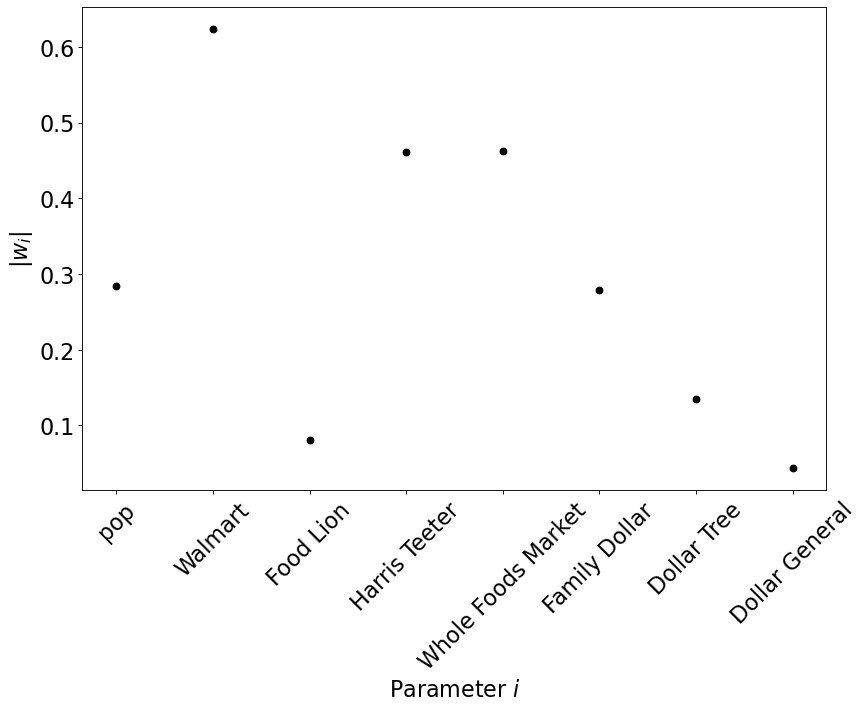

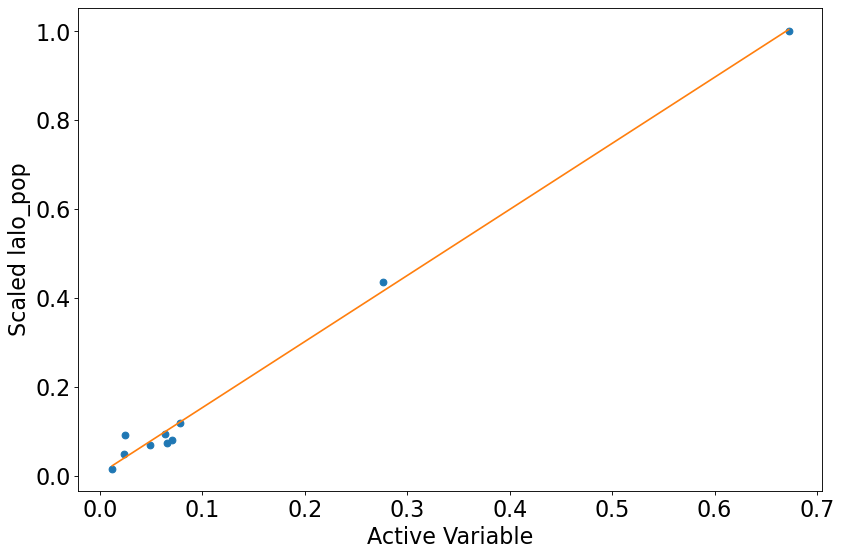

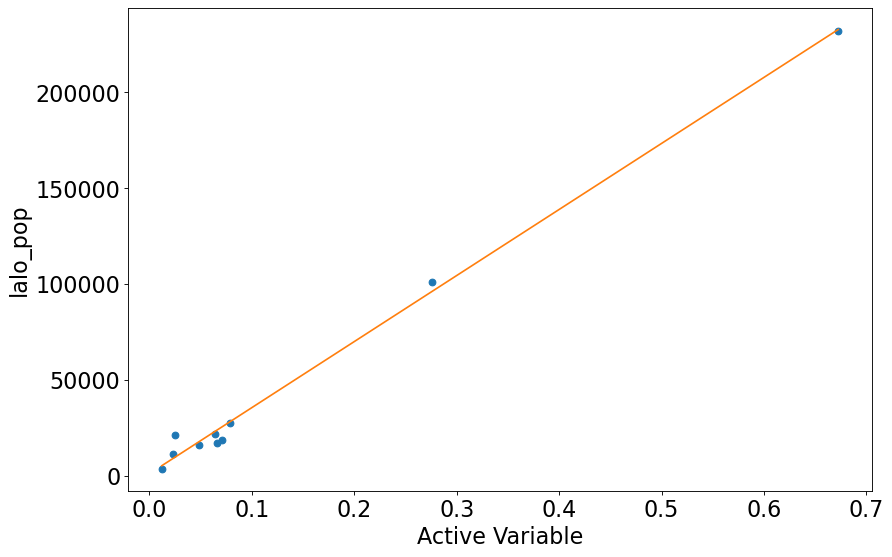

In [15]:
res = do_as(
    all_df, 
    ['pop', 'Walmart', 'Food Lion', 'Harris Teeter','Whole Foods Market', 'Family Dollar', 'Dollar Tree', 'Dollar General'], 
    "lalo_pop", norm="max"
)
as_plots(**res) 